#### Overview

1.  How does MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?
2. Is there a difference in revenue between 2018 and 2020?
3. What  is the difference in revenue for movie length of short vs. long

# Create project

In [2]:
# basic imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# SQL
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()

# Stats
import scipy.stats as stats
import statsmodels.api as sm

# settings
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

# Load Data and Process

#### Several step need to be taken to clean and prepare the data

-  for the first hypothesis drop movies with low counts in certification categories
- for the second hypothesis  the movies need to be grouped

## First Hypothesis prep

In [3]:
# load data of years 2010-2020
year_2010 = pd.read_csv('API_Data/final_tmdb_data_2010.csv.gz', low_memory = False)
year_2011 = pd.read_csv('API_Data/final_tmdb_data_2011.csv.gz', low_memory = False, lineterminator='\n')
year_2012 = pd.read_csv('API_Data/final_tmdb_data_2012.csv.gz', low_memory = False, lineterminator='\n')
year_2013 = pd.read_csv('API_Data/final_tmdb_data_2013.csv.gz', low_memory = False)
year_2014 = pd.read_csv('API_Data/final_tmdb_data_2014.csv.gz', low_memory = False, lineterminator='\n')
year_2015 = pd.read_csv('API_Data/final_tmdb_data_2015.csv.gz', low_memory = False, lineterminator='\n')
year_2016 = pd.read_csv('API_Data/final_tmdb_data_2016.csv.gz', low_memory = False)
year_2017 = pd.read_csv('API_Data/final_tmdb_data_2017.csv.gz', low_memory = False, lineterminator='\n')
year_2018 = pd.read_csv('API_Data/final_tmdb_data_2018.csv.gz', low_memory = False, lineterminator='\n')
year_2019 = pd.read_csv('API_Data/final_tmdb_data_2019.csv.gz', low_memory = False, lineterminator='\n')
year_2020 = pd.read_csv('API_Data/final_tmdb_data_2020.csv.gz', low_memory = False, lineterminator='\n')


In [4]:
#create new dataframe
tmdb_df = pd.concat([ year_2010,year_2011, year_2012, year_2013,year_2014, 
                     year_2015, year_2016, year_2017, 
                     year_2018, year_2019, year_2020])
tmdb_df.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.00,NaN,NaN,0.00,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,"23,738.00",en,Quantum Quest: A Cassini Space Odyssey,...,0.00,45.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.00,8.40,7.00,NaN
2,tt0326965,0.00,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.00,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,"40,048.00",en,In My Sleep,...,0.00,90.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.00,5.50,31.00,PG-13
3,tt0331312,0.00,NaN,NaN,0.00,[],NaN,"214,026.00",en,This Wretched Life,...,0.00,0.00,[],Released,NaN,This Wretched Life,0.00,5.00,1.00,NaN
4,tt0393049,0.00,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,"300,000.00","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,"324,352.00",en,Anderson's Cross,...,0.00,98.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.00,4.00,5.00,NaN


In [5]:
# look at info
tmdb_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40570 entries, 0 to 3717
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                40570 non-null  object 
 1   adult                  40559 non-null  float64
 2   backdrop_path          26186 non-null  object 
 3   belongs_to_collection  2384 non-null   object 
 4   budget                 40559 non-null  float64
 5   genres                 40559 non-null  object 
 6   homepage               11056 non-null  object 
 7   id                     40559 non-null  float64
 8   original_language      40559 non-null  object 
 9   original_title         40559 non-null  object 
 10  overview               39638 non-null  object 
 11  popularity             40559 non-null  float64
 12  poster_path            37225 non-null  object 
 13  production_companies   40559 non-null  object 
 14  production_countries   40559 non-null  object 
 15  rel

In [8]:
# look at  counts
tmdb_df['certification'].value_counts()


R          3307
NR         2404
PG-13      1859
PG          860
G           287
NC-17       111
Unrated       4
R             1
PG-13         1
10            1
Name: certification, dtype: int64

In [9]:
# fix low values
tmdb_df['certification'] = tmdb_df['certification'].replace({'R ': 'R',
                                                            'PG-13 ': 'PG-13'})
tmdb_df['certification'].value_counts()

R          3308
NR         2404
PG-13      1860
PG          860
G           287
NC-17       111
Unrated       4
10            1
Name: certification, dtype: int64

In [39]:
# import the data
filename = 'Data/tmdb_results_combined_df.csv.gz'
firsthypo_df=pd.read_csv(filename)
#check that the data loaded
firsthypo_df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.00,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,"10,000,000.00","[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,"62,127.00",en,The Fantasticks,...,0.00,86.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.00,5.50,22.00,NaN


In [12]:
#derop null values
tmdb_df = tmdb_df[tmdb_df.revenue !=0]



In [7]:
# explore the  missing data
num_missing = tmdb_df['certification'].isna().sum()

total_rows = tmdb_df.shape[0]

percent_missing = num_missing / total_rows
print(f'{percent_missing:.2f}% of the data in the certification column is missing')

0.00% of the data in the certification column is missing


In [49]:
# drop the unrated column
firsthypo_df = firsthypo_df.loc[firsthypo_df['certification'] != 'Unrated']

In [35]:
# drop the NC-17 column
firsthypo_df = firsthypo_df.loc[firsthypo_df['certification'] != 'NC-17']

In [50]:
# resolve small data counts by creating  new column  and check value
firsthypo_df['certification'].value_counts()

R        467
PG-13    182
NR        71
PG        63
G         25
NC-17      6
Name: certification, dtype: int64

In [31]:
#drop null values in certification column
firsthypo_df = firsthypo_df.dropna(subset=['certification'])

In [32]:
firsthypo_df['genres'].describe()


count                               814
unique                              332
top       [{'id': 18, 'name': 'Drama'}]
freq                                 70
Name: genres, dtype: object

In [7]:
# resolve small data counts by creating  new column  and check value
firsthypo_df['certification'].value_counts()

R        205
PG-13    125
PG        34
G         13
NR        12
Name: certification, dtype: int64

## Second Hypothesis prep

In [8]:
#read the data
df_2018 = pd.read_json('API_Data/tmdb_api_results_2018.json')
df_2018.head()


,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0069049,0.00,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,None,"12,000,000.00","[{'id': 18, 'name': 'Drama'}]",https://www.netflix.com/title/80085566,"299,782.00",en,The Other Side of the Wind,...,0.00,122.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,40 years in the making,The Other Side of the Wind,0.00,6.70,155.00,R
2,tt0192528,0.00,/kOxAfSyHZEDEhOCic8TxXprUg4T.jpg,None,"5,000,000.00","[{'id': 18, 'name': 'Drama'}]",None,"567,662.00",en,Reverse Heaven,...,0.00,104.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Heaven's in trouble and there's one man who ca...,Heaven & Hell,0.00,7.20,5.00,
3,tt0360556,0.00,/7oy4miyq4WYYy0xtX6lbNVPrEsr.jpg,None,0.00,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",https://www.hbo.com/movies/fahrenheit-451,"401,905.00",en,Fahrenheit 451,...,0.00,100.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Knowledge is a dangerous thing,Fahrenheit 451,0.00,5.40,686.00,PG-13
4,tt0365545,0.00,/ljTYcQ3pkzYF52Z8ev1Z1UThnPy.jpg,None,0.00,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",https://www.netflix.com/title/80189630,"519,035.00",en,Nappily Ever After,...,0.00,100.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Let yourself grow,Nappily Ever After,0.00,7.20,752.00,


In [9]:
#loading 2021 data, errors in reading 2020 data
df_2021 = pd.read_csv('API_Data/final_tmdb_data_2001.csv.gz', low_memory=False)
df_2021.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.00,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,"48,000,000.00","[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,"11,232.00",en,Kate & Leopold,...,"76,019,048.00",118.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.00,6.33,"1,195.00",PG-13


In [10]:
# create one dataframe
combinedyears = pd.concat([df_2018, df_2021])

In [11]:
#seperate out years
combinedyears['release_date'] = pd.to_datetime(combinedyears['release_date'])

In [12]:
#create year column
combinedyears['year'] = combinedyears['release_date'].dt.year
combinedyears.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5857 entries, 0 to 1336
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   imdb_id                5857 non-null   object        
 1   adult                  5855 non-null   float64       
 2   backdrop_path          4170 non-null   object        
 3   belongs_to_collection  319 non-null    object        
 4   budget                 5855 non-null   float64       
 5   genres                 5855 non-null   object        
 6   homepage               4182 non-null   object        
 7   id                     5855 non-null   float64       
 8   original_language      5855 non-null   object        
 9   original_title         5855 non-null   object        
 10  overview               5827 non-null   object        
 11  popularity             5855 non-null   float64       
 12  poster_path            5612 non-null   object        
 13  pro

In [13]:
# drop null values
combinedyears = combinedyears.dropna(subset=['year','revenue'])

In [14]:
#create 2001 column
combinedyears['year_2021'] = combinedyears['year'] == 2021

In [15]:
#check values
combinedyears['year_2021'].value_counts()

False    5736
True       23
Name: year_2021, dtype: int64

In [16]:
## save list of columns needed for each group
needed_cols = ['year_2021', 'revenue']

In [17]:
## save year_2021 in separate variable
year_2021_df = combinedyears.loc[combinedyears['year_2021']==True, needed_cols]
year_2021_df

,year_2021,revenue
123,True,0.00
126,True,0.00
127,True,0.00
248,True,0.00
600,True,0.00
764,True,0.00
980,True,0.00
1022,True,0.00
1260,True,0.00
1306,True,0.00


In [18]:
## save year_2018 in separate variable
year_2018_df = combinedyears.loc[combinedyears['year_2021']==False, needed_cols]
year_2018_df

,year_2021,revenue
1,False,0.00
2,False,0.00
3,False,0.00
4,False,0.00
5,False,0.00
...,...,...
1332,False,0.00
1333,False,0.00
1334,False,0.00
1335,False,0.00


In [19]:
## Saving JUST the numeric col as final group variables
year_2021_group = year_2021_df['revenue']
year_2018_group = year_2018_df['revenue']
year_2021_group

123    0.00
126    0.00
127    0.00
248    0.00
600    0.00
764    0.00
980    0.00
1022   0.00
1260   0.00
1306   0.00
1314   0.00
1887   0.00
1972   0.00
2049   0.00
2106   0.00
2381   0.00
2689   0.00
2838   0.00
3528   0.00
4018   0.00
4116   0.00
4495   0.00
712    0.00
Name: revenue, dtype: float64

## Third Hypothesis prep

In [20]:
#explore runtime
firsthypo_df['runtime'].describe()

count   546.00
mean    104.60
std      22.40
min       0.00
25%      91.00
50%     100.00
75%     114.00
max     224.00
Name: runtime, dtype: float64

In [21]:
# look at runtime
firsthypo_df['runtime'].value_counts()

90.00     28
99.00     18
95.00     18
108.00    18
98.00     18
          ..
199.00     1
77.00      1
165.00     1
216.00     1
70.00      1
Name: runtime, Length: 87, dtype: int64

In [22]:
# create groups
long_film_df = firsthypo_df.loc[firsthypo_df['runtime'] > 150].copy()
short_film_df = firsthypo_df.loc[firsthypo_df['runtime'] < 90].copy()

In [23]:
display(long_film_df.info(), short_film_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 61 to 2527
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                22 non-null     object 
 1   adult                  22 non-null     float64
 2   backdrop_path          20 non-null     object 
 3   belongs_to_collection  3 non-null      object 
 4   budget                 22 non-null     float64
 5   genres                 22 non-null     object 
 6   homepage               3 non-null      object 
 7   id                     22 non-null     float64
 8   original_language      22 non-null     object 
 9   original_title         22 non-null     object 
 10  overview               22 non-null     object 
 11  popularity             22 non-null     float64
 12  poster_path            22 non-null     object 
 13  production_companies   22 non-null     object 
 14  production_countries   22 non-null     object 
 15  relea

None

None

In [24]:
longfilm_runtime = long_film_df['runtime']
shortfilm_runtime = short_film_df['runtime']

# First Hypothesis Testing
#### What are the differences in  revenue for movie ratings?


- $H_0$ (Null Hypothesis): Movies have the same revenue in all MPAA ratings
- $H_A$ (Alternative Hypothesis): Movies with different MPAA ratings have different revenue.

Possible question: How much is the differences using linear regression
  -  For this question rating will need to be grouped. 


## Test types: ANOVA and Kruskall

In [13]:
# Create groups dictionary.
groups = {}
## Loop through all unique categories
for rating in tmdb_df['certification'].unique():
    ## Get series for group and rename
    data = tmdb_df.loc[tmdb_df['certification']==rating,'revenue'].copy()
    
    # save into the dictionary
    groups[rating] = data
groups.keys()

dict_keys(['PG', 'R', 'PG-13', 'G', 'NR', 'NC-17'])

### Check Assumptions for ANOVA
- normality
- equal variance
- outliers

### Normality

In [14]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG,343.00,0.00,186.70
R,"1,273.00",0.00,"1,162.96"
PG-13,892.00,0.00,694.21
G,60.00,0.00,54.97
NR,175.00,0.00,248.23
NC-17,13.00,0.11,4.33


In [16]:

## Save a list with an inner list of column names
norm_results = [['group','n','pval','sig?']]


## loop through group dict
for rating, data in groups.items():
    ## calculate normaltest results
    stat, p = stats.normaltest(data)
    
    ## Append the right info into norm_resutls (as a list)
    norm_results.append([rating,len(data), p, p<.05])
    
    
## Make norm_results a dataframe (first row is columns, everything else data)
normal_results = pd.DataFrame(norm_results[1:], columns = norm_results[0])
normal_results

,group,n,pval,sig?
0,PG,332,0.00,True
1,R,1243,0.00,True
2,PG-13,868,0.00,True
3,G,58,0.00,True
4,NR,172,0.00,True
5,NC-17,13,0.11,False


#### The data  failed the assumpution for normality for G, PG, PG-13, R, and NR groups, but these groups are large enough that we can safely disregard the assumption of normality.

### Check for Outliers

In [15]:
## Loop through groups dict
for rating, data in groups.items():

    ## determine if there are any outliers
    outliers = np.abs(stats.zscore(data)) > 3
    
    ## print a statement about how many outliers for which group name
    print(f"There were {outliers.sum()} outliers in the {rating} group.")

    ## Remove the outiers from data and overwrite the rating data in the dict
    data = data.loc[~outliers]
    groups[rating] = data

There were 11 outliers in the PG group.
There were 30 outliers in the R group.
There were 24 outliers in the PG-13 group.
There were 2 outliers in the G group.
There were 3 outliers in the NR group.
There were 0 outliers in the NC-17 group.


### Equal Variance

In [17]:
## Use Levene's test for equal variance
result = stats.levene(*groups.values())
print(result)

LeveneResult(statistic=66.73338110641302, pvalue=7.093189576096272e-66)


In [18]:
## Use an if-else to help interpret the p-value
if result.pvalue < 0.5:
    print(f'The groups do NOT have equal variance.')
else:
    print(f'the groups DO have equal variance.')

The groups do NOT have equal variance.


- The null hypothesis is rejected the null hypothesis of equal variance.
- The ANOVA test is not appropriate, Kruskal-Wallis test is the correct test.

###  Run Kruskall Wallace test

In [19]:
## Running Krukal Test for Original Hypothesis
result = stats.kruskal(*groups.values())
print(result)
result.pvalue<.05

KruskalResult(statistic=456.6633529097644, pvalue=1.794220577005223e-96)


True

### Interpretation
- The p value is less 0.05. From this data the null hypothesis is rejected. There is a difference between revenue in the different MPAA ratings

### Visual  for First Hypothesis

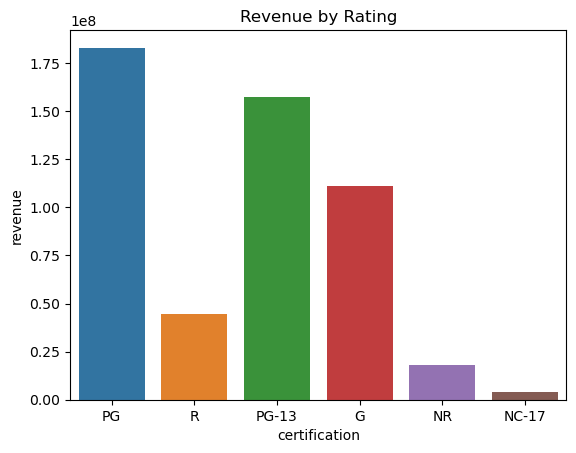

In [21]:
#visualize the data
ax= sns.barplot(data = tmdb_df, x='certification',y='revenue', errorbar=None);
ax.set_title("Revenue by Rating");